本笔记本说明了我们如何探索和准备用于模型构建的数据。笔记本的结构如下：

 - 数据集介绍
 - 数据概要
 - 特征工程
 - 缺失值分析
 - 异常值分析
 - 相关性分析
 - 数据分布可视化
 - 计数与（月份、季节、小时、工作日、用户类型）的关系可视化
 - 使用随机森林填充风速中的0值
 - 线性回归模型
 - 正则化模型
 - 集成模型

## 数据集介绍

#### **概述**

共享单车系统是一种租赁自行车的方式，通过城市各处的自动化站点网络，实现会员注册、租赁和还车的自动化过程。使用这些系统，人们可以在一个地点租车，并在需要时将其归还到不同的地点。目前，全球有超过500个共享单车项目。

#### **数据字段**

* datetime - 小时日期 + 时间戳
* season - 1 = 春季, 2 = 夏季, 3 = 秋季, 4 = 冬季
* holiday - 是否为假日
* workingday - 是否为工作日（非周末或假日）
* weather - 天气情况：
    * 1: 晴天、少云、局部多云
    * 2: 薄雾 + 多云、薄雾 + 碎云、薄雾 + 少云、薄雾
    * 3: 小雪、小雨 + 雷暴 + 散云、小雨 + 散云
    * 4: 大雨 + 冰雹 + 雷暴 + 薄雾、雪 + 雾
* temp - 温度（摄氏度）
* atemp - "体感"温度（摄氏度）
* humidity - 相对湿度
* windspeed - 风速
* casual - 非注册用户租赁数量
* registered - 注册用户租赁数量
* count - 租赁总数量（因变量）

In [35]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#### **Lets Read In The Dataset**

In [36]:
dailyData = pd.read_csv("./data/train.csv")

## Data Summary

As a first step lets do three simple steps on the dataset

 - Size of the dataset
 - Get a glimpse of data by printing few rows of it.
 - What type of variables contribute our data

#### **Shape Of The Dataset**

In [37]:
dailyData.shape

(10886, 12)

#### **Sample Of First Few Rows**

In [38]:
dailyData.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


#### **Variables Data Type**

In [39]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## 特征工程

从上述结果可以看出，"season"、"holiday"、"workingday"和"weather"列应该是"分类"数据类型。但当前这些列的数据类型是"int"。让我们通过以下方式转换数据集，以便开始我们的探索性数据分析：

 - 从"datetime"列创建新的"date"、"hour"、"weekDay"、"month"列
 - 将"season"、"holiday"、"workingday"和"weather"的数据类型强制转换为category
 - 删除datetime列，因为我们已经从中提取了有用的特征


#### **Creating New Columns From "Datetime" Column**

In [40]:
dailyData["date"] = dailyData.datetime.apply(lambda x : x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x : x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

#### **Coercing To Category Type**

In [41]:
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

#### **Dropping Unncessary Columns**

In [42]:
dailyData  = dailyData.drop(["datetime"],axis=1)

#### **Lets Start With Very Simple Visualization Of Variables DataType Count**

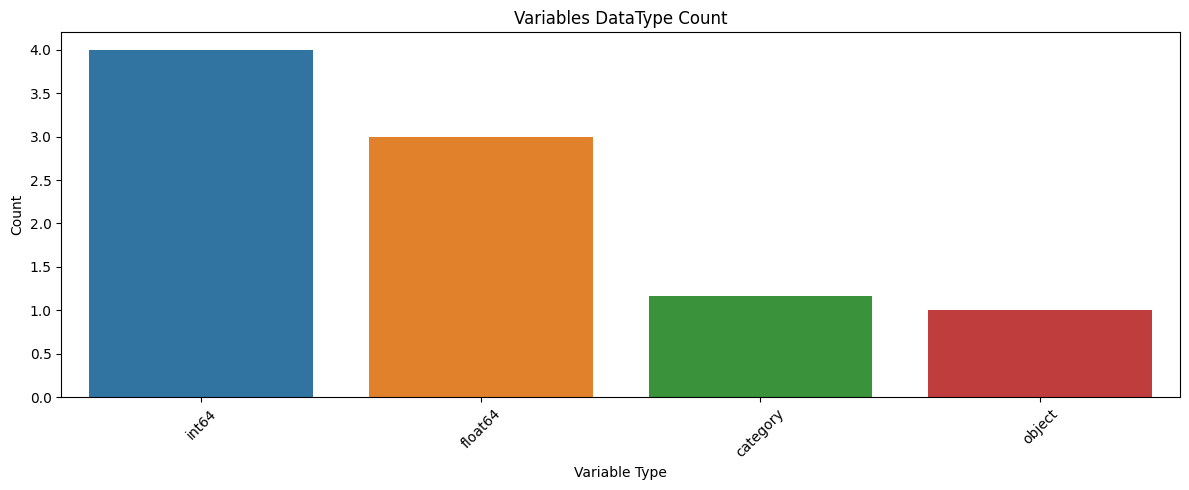

In [43]:
# 1. 获取数据类型的值计数
type_counts = dailyData.dtypes.value_counts()

# 2. 创建DataFrame
dataTypeDf = pd.DataFrame({
    'variableType': type_counts.index.astype(str),
    'count': type_counts.values
})

# 3. 创建图形
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

# 4. 绘制条形图，添加 ci=None 来移除误差线
sn.barplot(data=dataTypeDf, x="variableType", y="count", ax=ax, errorbar=None)

# 5. 设置图形标签
ax.set(
    xlabel='Variable Type',
    ylabel='Count',
    title="Variables DataType Count"
)

# 6. 优化显示
plt.xticks(rotation=45)  # 旋转x轴标签以防重叠
plt.tight_layout()       # 自动调整布局

## 缺失值分析

一旦我们掌握了数据和列的情况，下一步通常是找出数据中是否存在任何缺失值。幸运的是，我们的数据集中没有任何缺失值。我通常喜欢使用"missingno"来可视化数据集中的缺失值。

这是一个非常方便的库，可以快速可视化变量的缺失值。正如我之前提到的，这次我们很幸运，因为数据集中没有缺失值。


## 分布偏度

<AxesSubplot:>

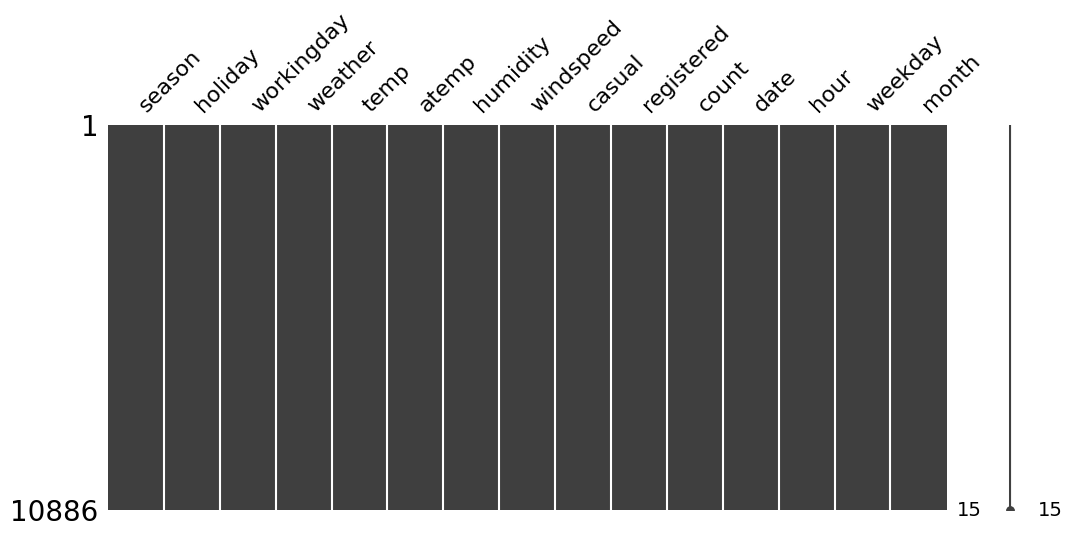

In [44]:
msno.matrix(dailyData,figsize=(12,5))

## 异常值分析

初看之下，"count"变量包含许多异常数据点，这使得分布向右偏斜（因为有更多的数据点超出了外四分位限）。但除此之外，从下面的简单箱线图中还可以得出以下结论：

 - 春季的租赁数量相对较低。箱线图中位数值的下降证实了这一点。
 - "每日小时数"的箱线图非常有趣。在上午7-8点和下午5-6点，中位数值相对较高。这可以归因于该时段的常规上学和上班用户。
 - 大多数异常点主要来自"工作日"而不是"非工作日"。从图4中可以清楚地看到这一点。


[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

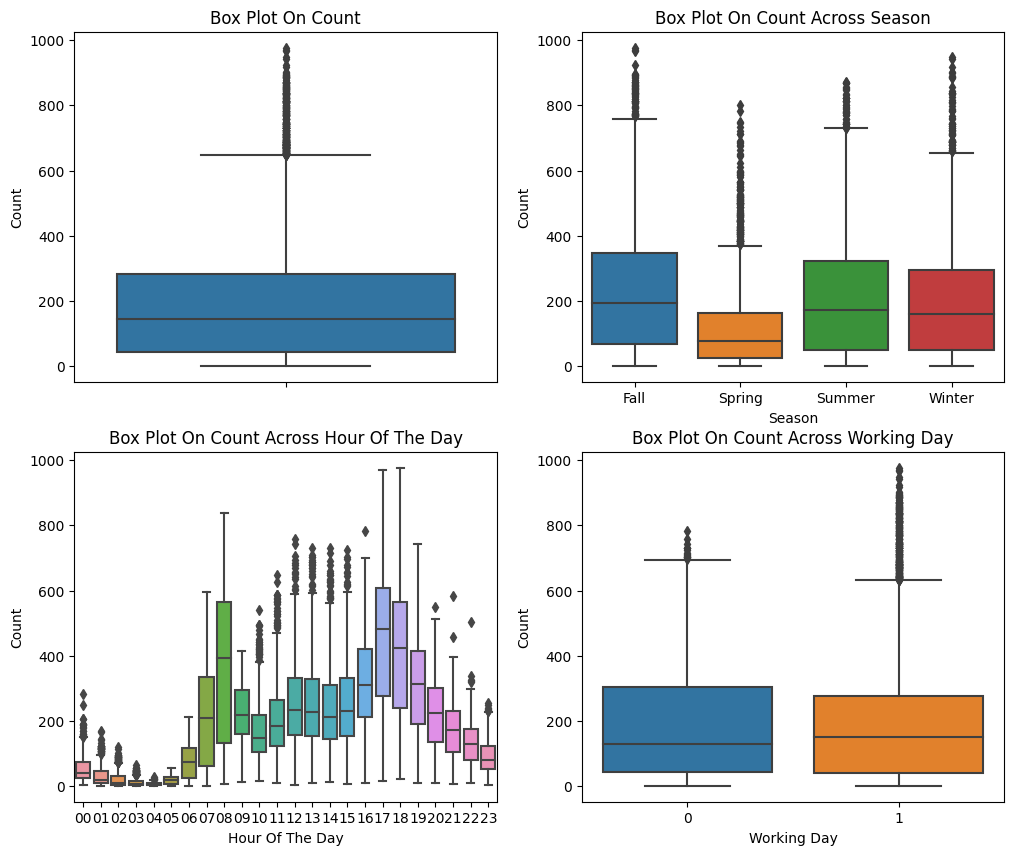

In [45]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#### **Lets Remove Outliers In The Count Column**

In [46]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"]-dailyData["count"].mean())<=(3*dailyData["count"].std())] 

In [47]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


## 相关性分析

理解因变量如何受到特征（数值型）影响的一种常见方法是找出它们之间的相关矩阵。让我们绘制"count"与["temp","atemp","humidity","windspeed"]之间的相关图。

 - temp和humidity特征与count分别呈正相关和负相关。虽然它们之间的相关性不是很显著，但count变量与"temp"和"humidity"仍有一定的依赖关系。
 - windspeed不会是真正有用的数值特征，这从它与"count"的相关值可以看出。
 - "atemp"变量没有被考虑，因为"atemp"和"temp"之间存在强相关性。在模型构建过程中，必须删除其中一个变量，因为它们会在数据中表现出多重共线性。
 - "Casual"和"Registered"也没有被考虑，因为它们本质上是泄露变量，在模型构建过程中需要删除。

seaborn中的回归图是描述两个特征之间关系的一种有用方式。这里我们考虑"count"与"temp"、"humidity"、"windspeed"的关系。


<AxesSubplot:>

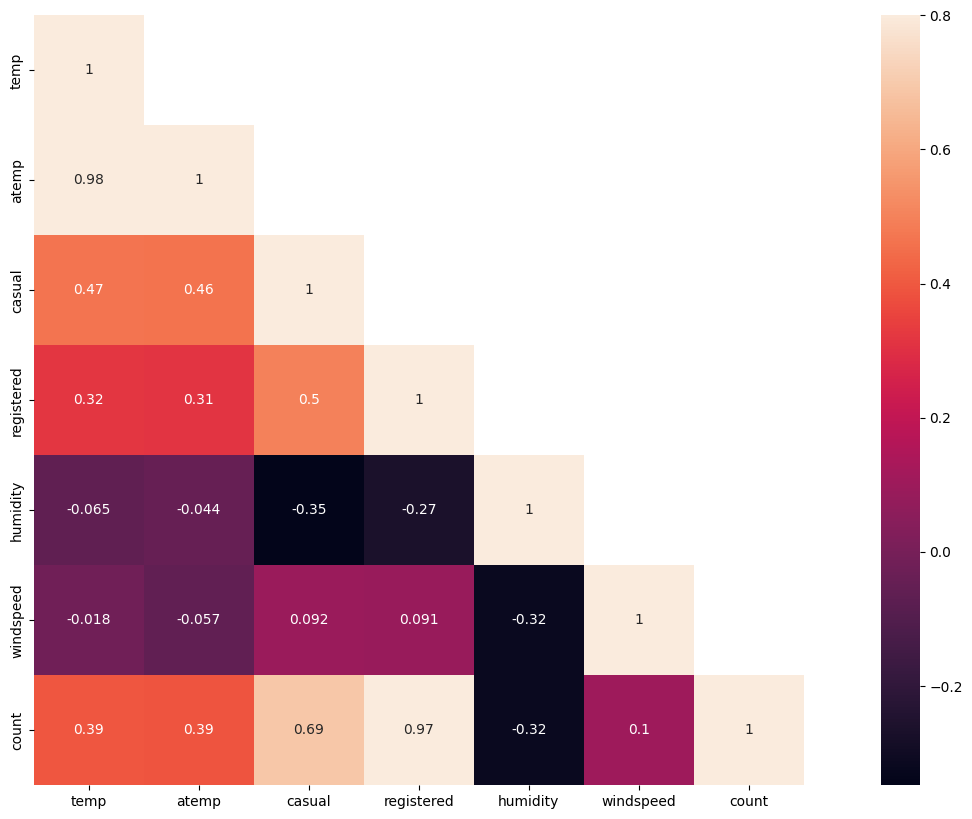

In [48]:
corrMatt = dailyData[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

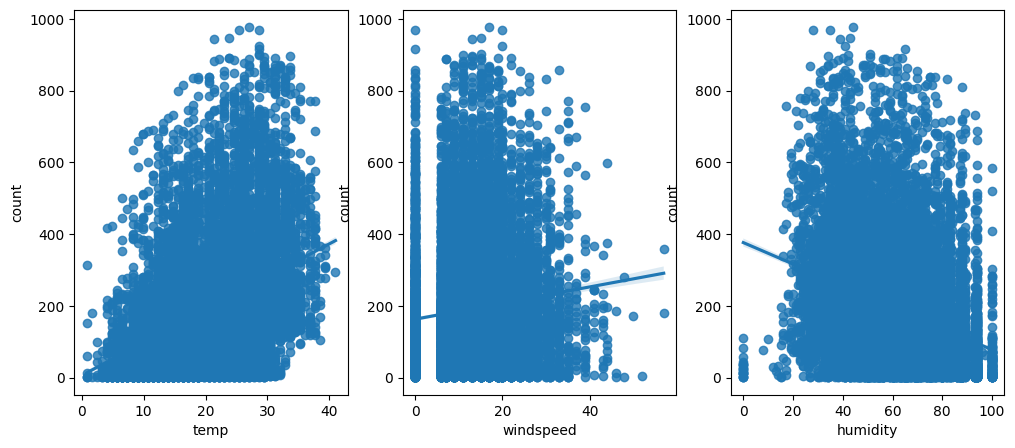

In [49]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData,ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData,ax=ax3)

## 数据分布可视化
从下图可以看出，"count"变量向右偏斜。由于大多数机器学习技术要求因变量呈正态分布，因此最好是正态分布。一个可能的解决方案是在删除异常数据点后对"count"变量进行对数转换。转换后的数据看起来好多了，但仍然不是完全理想的正态分布。


d:\Development\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  This is separate from the ipykernel package so we can avoid doing imports until
d:\Development\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229772, 4.562423868087808, 0.958117678090961))

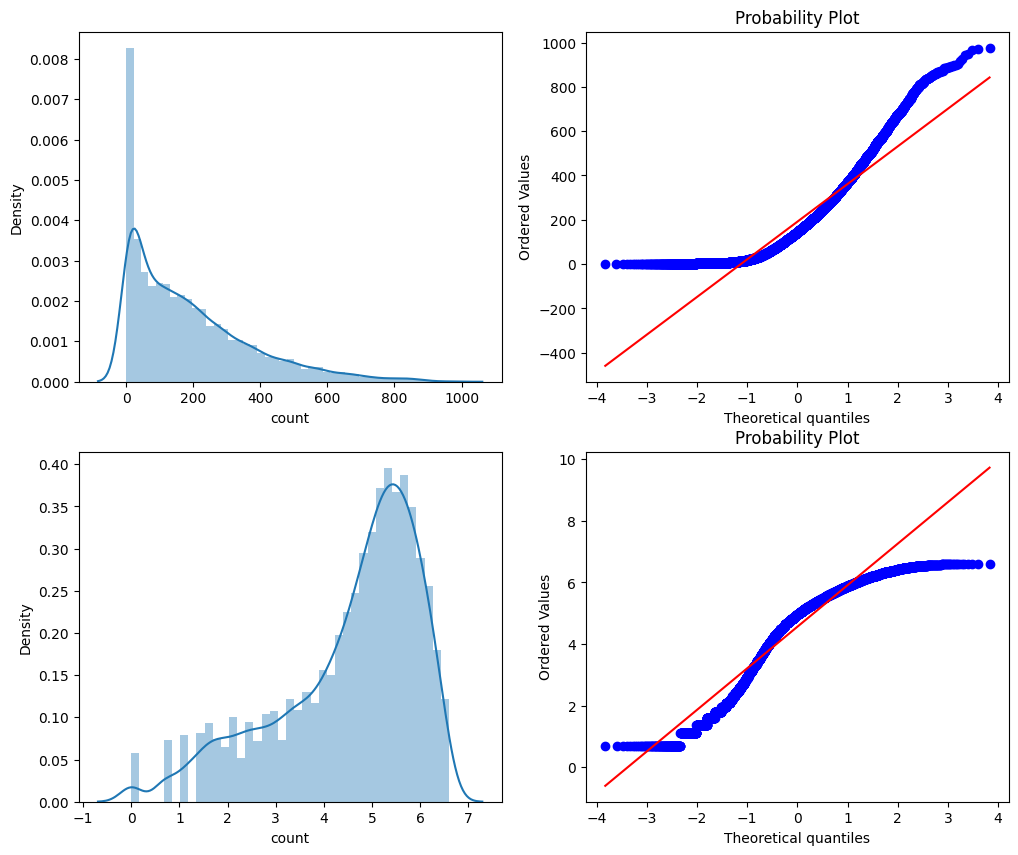

In [50]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"],ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

## 计数与（月份、季节、小时、工作日、用户类型）的可视化

 - 很明显，人们倾向于在夏季租用自行车，因为那个季节骑自行车的条件真的很好。因此，六月、七月和八月的自行车需求相对较高。
 - 在工作日，更多人倾向于在上午7-8点和下午5-6点租用自行车。如前所述，这可以归因于常规的上学和上班通勤者。
 - 在"周六"和"周日"没有观察到上述模式。更多人倾向于在上午10点到下午4点之间租用自行车。
 - 上午7-8点和下午5-6点的用户高峰完全是由注册用户贡献的。


[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

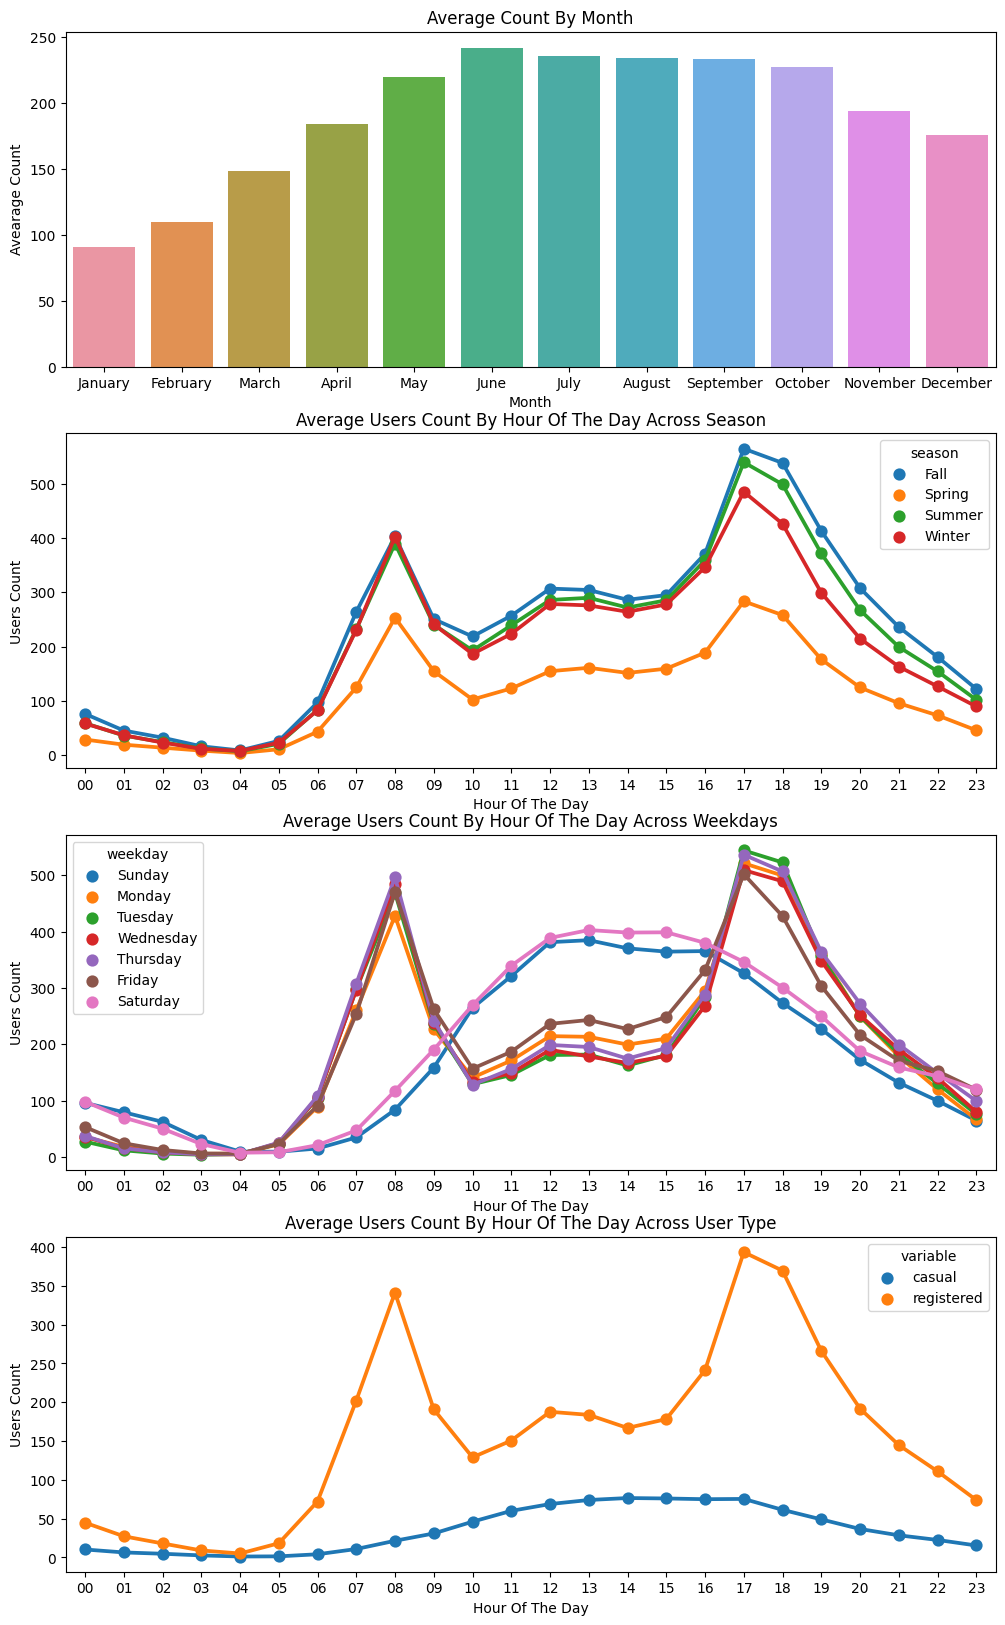

In [51]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sn.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(dailyData.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourTransformed = pd.melt(dailyData[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

**所以我们已经对数据进行了充分的可视化。现在让我们去构建一些模型，看看我们能多接近地预测结果。**


## Filling 0's In windspeed Using Random Forest ##

**读取训练和测试数据**

In [52]:
dataTrain = pd.read_csv("./data/train.csv")
dataTest = pd.read_csv("./data/test.csv")

**Combine Train And Test**

In [53]:
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**Feature Engineering**

In [54]:
data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

**Random Forest Model To Predict 0's In Windspeed**

In [55]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

**Coercing To Categorical Type**

In [56]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [57]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

**Splitting Train And Test Data**

In [58]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLablesRegistered = dataTrain["registered"]
yLablesCasual = dataTrain["casual"]

**Dropping  Unncessary Variables**

In [59]:
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

**RMSLE Scorer**

In [60]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [61]:
# 存储所有模型的预测结果
all_preds_train = []
all_preds_test = []

## **Linear Regression Model** ##

In [62]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds_lmodel_train = lModel.predict(X= dataTrain)
preds_lmodel_test = lModel.predict(dataTest)
all_preds_train.append(np.exp(preds_lmodel_train))
all_preds_test.append(np.exp(preds_lmodel_test))
print("RMSLE Value For Linear Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds_lmodel_train), False))

RMSLE Value For Linear Regression:  0.9779705063131331


d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:976: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  estimator=estimator,
d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values exp

d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values e

Best parameters For Ridge: {'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779704912506045


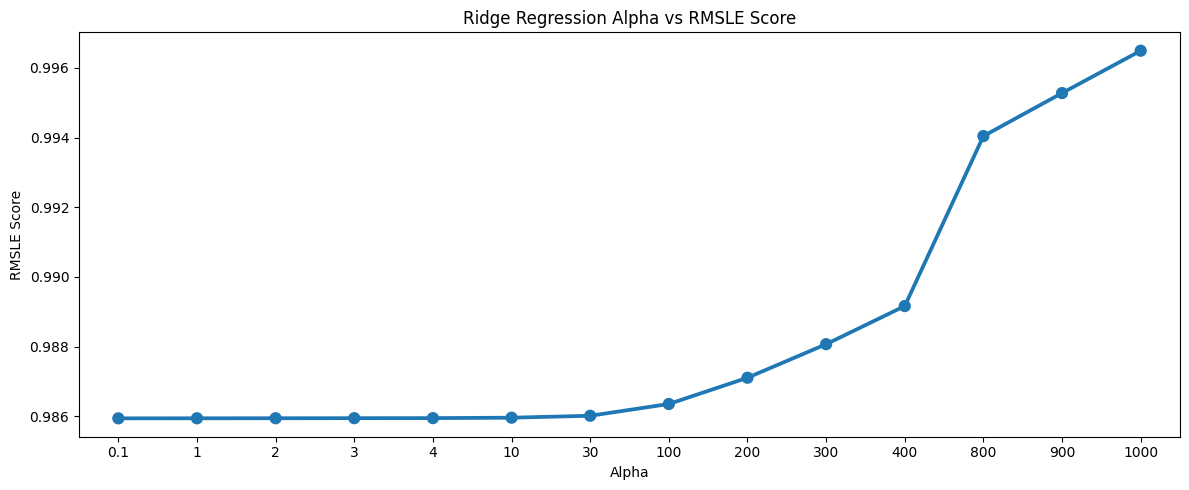

In [63]:
ridge_m_ = Ridge()
ridge_params_ = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# 创建GridSearchCV对象
grid_ridge_m = GridSearchCV(
    ridge_m_,
    ridge_params_,
    scoring=rmsle_scorer,
    cv=5
)

# 训练模型
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit(dataTrain, yLabelsLog)
preds_ridge_train = grid_ridge_m.predict(dataTrain)
preds_ridge_test = grid_ridge_m.predict(dataTest)
all_preds_train.append(np.exp(preds_ridge_train))
all_preds_test.append(np.exp(preds_ridge_test))
print("Best parameters For Ridge:", grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds_ridge_train), False))

# 可视化结果
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

# 使用cv_results_创建DataFrame
df = pd.DataFrame({
    'alpha': grid_ridge_m.cv_results_['param_alpha'],
    'rmsle': -grid_ridge_m.cv_results_['mean_test_score']  # 注意负号，因为我们使用了greater_is_better=False
})

# 绘制图形
sn.pointplot(data=df, x='alpha', y='rmsle', ax=ax)
ax.set(
    xlabel='Alpha',
    ylabel='RMSLE Score',
    title='Ridge Regression Alpha vs RMSLE Score'
)
plt.tight_layout()

## **Regularization Model - Lasso** ##

d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values e

Best parameters For Lasso: {'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9781072847475938


d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
d:\Development\anaconda3\envs\ml\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


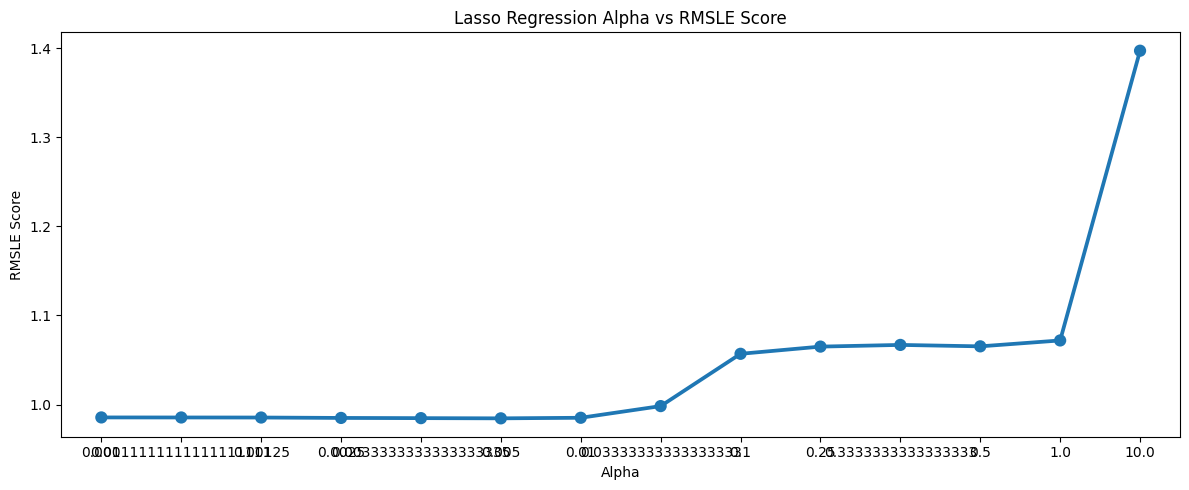

In [64]:
# 初始化Lasso模型
lasso_m_ = Lasso()

# 设置alpha参数
alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params_ = {'max_iter':[3000], 'alpha':alpha}

# 创建GridSearchCV对象
grid_lasso_m = GridSearchCV(
    lasso_m_,
    lasso_params_,
    scoring=rmsle_scorer,
    cv=5
)

# 训练模型
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(dataTrain, yLabelsLog)
preds_lasso_train = grid_lasso_m.predict(dataTrain)
preds_lasso_test = grid_lasso_m.predict(dataTest)
all_preds_train.append(np.exp(preds_lasso_train))
all_preds_test.append(np.exp(preds_lasso_test))
print("Best parameters For Lasso:", grid_lasso_m.best_params_)
print("RMSLE Value For Lasso Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds_lasso_train), False))


# 可视化结果
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

# 使用cv_results_创建DataFrame
df = pd.DataFrame({
    'alpha': grid_lasso_m.cv_results_['param_alpha'],
    'rmsle': -grid_lasso_m.cv_results_['mean_test_score']  # 注意负号，因为我们使用了greater_is_better=False
})

# 绘制图形
sn.pointplot(data=df, x='alpha', y='rmsle', ax=ax)
ax.set(
    xlabel='Alpha',
    ylabel='RMSLE Score',
    title='Lasso Regression Alpha vs RMSLE Score'
)
plt.tight_layout()

## **Ensemble Models - Random Forest**

In [65]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds_rf_train = rfModel.predict(dataTrain)
preds_rf_test = rfModel.predict(dataTest)
all_preds_train.append(np.exp(preds_rf_train))
all_preds_test.append(np.exp(preds_rf_test))
print("RMSLE Value For Random Forest: ", rmsle(np.exp(yLabelsLog), np.exp(preds_rf_train), False))

RMSLE Value For Random Forest:  0.10332310216545845


## **Ensemble Model - Gradient Boost** ##

In [66]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds_gbm_train = gbm.predict(dataTrain)
preds_gbm_test = gbm.predict(dataTest)
all_preds_train.append(np.exp(preds_gbm_train))
all_preds_test.append(np.exp(preds_gbm_test))
print("RMSLE Value For Gradient Boost: ", rmsle(np.exp(yLabelsLog), np.exp(preds_gbm_train), False))

RMSLE Value For Gradient Boost:  0.18900500510785306


**Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. It  confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.**

RMSLE Value For Averaged Predictions (Training):  0.619796403339131


d:\Development\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
d:\Development\anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


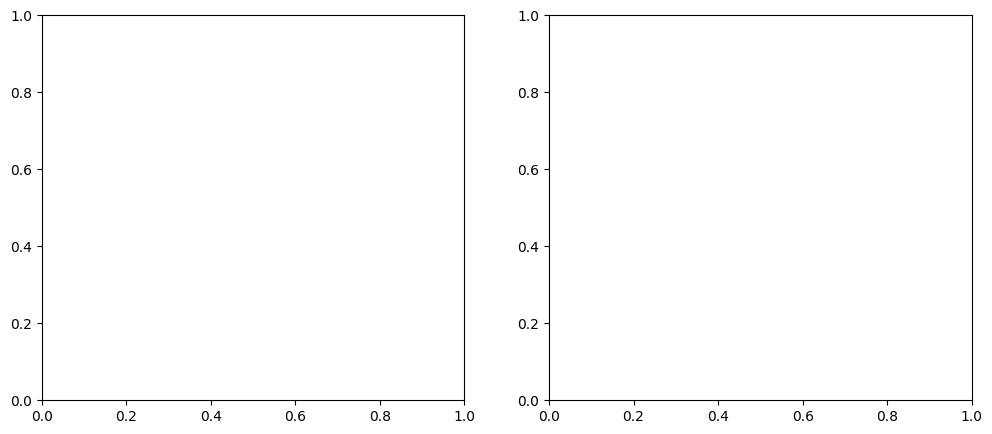

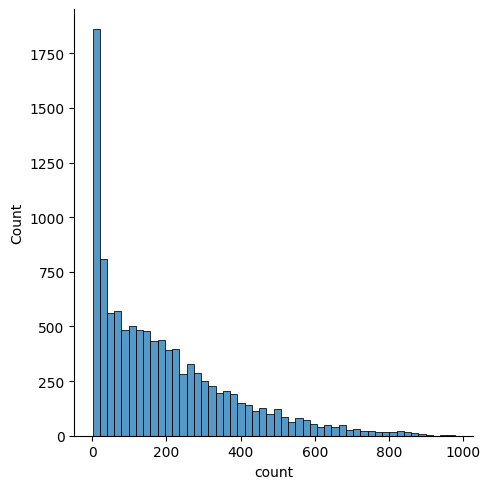

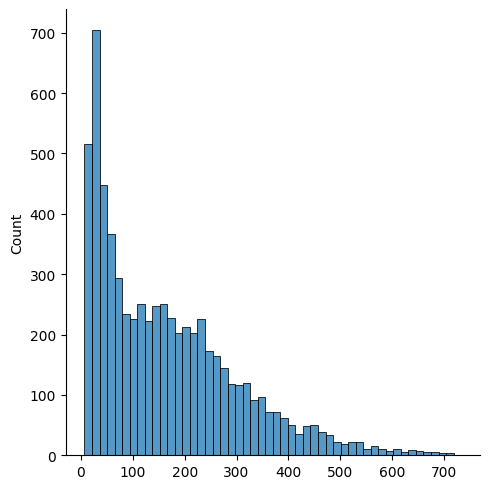

Submission file created with averaged predictions.


In [67]:
# 对所有模型的训练集预测结果取平均值
averaged_preds_train = np.mean(all_preds_train, axis=0)
print("RMSLE Value For Averaged Predictions (Training): ", rmsle(np.exp(yLabelsLog), averaged_preds_train, False))

# 对所有模型的测试集预测结果取平均值
averaged_preds_test = np.mean(all_preds_test, axis=0)

# 可视化平均预测结果
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)
sn.displot(yLabels, ax=ax1, bins=50)
sn.displot(averaged_preds_test, ax=ax2, bins=50)
plt.show()

# 生成提交文件
submission = pd.DataFrame({
    "datetime": datetimecol,
    "count": [max(0, x) for x in averaged_preds_test]
})
submission.to_csv('bike_predictions_averaged_ensemble.csv', index=False)

print("Submission file created with averaged predictions.")

**The submission will have test score of 0.41**